In [1]:
### Load the required libraries

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import requests
import re

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
%%time
import nltk
nltk.download('omw-1.4')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

from tqdm import tqdm, tqdm_notebook
from wordcloud import WordCloud

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import joblib
from joblib import Memory
import os
import time

Wall time: 1.52 s


[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\91994\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
### To read the useful csv file into DataFrame

df = pd.read_csv(r"data/reviews_badminton.csv")

In [4]:
df

,Reviewer Name,Review Title,Place of Review,Up Votes,Down Votes,Month,Review text,Ratings
0,Kamal Suresh,Nice product,"Certified Buyer, Chirakkal",889.0,64.0,Feb 2021,"Nice product, good quality, but price is now r...",4
1,Flipkart Customer,Don't waste your money,"Certified Buyer, Hyderabad",109.0,6.0,Feb 2021,They didn't supplied Yonex Mavis 350. Outside ...,1
2,A. S. Raja Srinivasan,Did not meet expectations,"Certified Buyer, Dharmapuri",42.0,3.0,Apr 2021,Worst product. Damaged shuttlecocks packed in ...,1
3,Suresh Narayanasamy,Fair,"Certified Buyer, Chennai",25.0,1.0,NaN,"Quite O. K. , but nowadays the quality of the...",3
4,ASHIK P A,Over priced,NaN,147.0,24.0,Apr 2016,Over pricedJust â?¹620 ..from retailer.I didn'...,1
...,...,...,...,...,...,...,...,...
8513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
8514,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
8515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
8516,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8518 entries, 0 to 8517
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Reviewer Name    8508 non-null   object 
 1   Review Title     8508 non-null   object 
 2   Place of Review  8468 non-null   object 
 3   Up Votes         8508 non-null   float64
 4   Down Votes       8508 non-null   float64
 5   Month            8053 non-null   object 
 6   Review text      8510 non-null   object 
 7   Ratings          8518 non-null   int64  
dtypes: float64(2), int64(1), object(5)
memory usage: 532.5+ KB


In [6]:
df.shape

(8518, 8)

In [7]:
df.columns

Index(['Reviewer Name', 'Review Title', 'Place of Review', 'Up Votes',
       'Down Votes', 'Month', 'Review text', 'Ratings'],
      dtype='object')

In [8]:
df.isnull().sum()

Reviewer Name       10
Review Title        10
Place of Review     50
Up Votes            10
Down Votes          10
Month              465
Review text          8
Ratings              0
dtype: int64

In [9]:
mode_review_text = df.groupby('Ratings')['Review text'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None).reset_index()
mode_review_title = df.groupby('Ratings')['Review Title'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None).reset_index()
mode_review_up_votes = df.groupby('Ratings')['Up Votes'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None).reset_index()
mode_review_down_votes = df.groupby('Ratings')['Down Votes'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None).reset_index()
mode_reviewer_name = df.groupby('Ratings')['Reviewer Name'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None).reset_index()
mode_place_of_review = df.groupby('Ratings')['Place of Review'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None).reset_index()
mode_review_month = df.groupby('Ratings')['Month'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None).reset_index()

In [10]:
mode_review_text

,Ratings,Review text
0,1,Not goodREAD MORE
1,2,Quality is not goodREAD MORE
2,3,GoodREAD MORE
3,4,GoodREAD MORE
4,5,GoodREAD MORE


In [11]:
mode_review_title

,Ratings,Review Title
0,1,Did not meet expectations
1,2,Not good
2,3,Wonderful
3,4,Wonderful
4,5,Wonderful


In [12]:
mode_review_up_votes

,Ratings,Up Votes
0,1,0.0
1,2,0.0
2,3,0.0
3,4,0.0
4,5,0.0


In [13]:
mode_review_down_votes

,Ratings,Down Votes
0,1,0.0
1,2,0.0
2,3,0.0
3,4,0.0
4,5,0.0


In [14]:
mode_reviewer_name

,Ratings,Reviewer Name
0,1,Flipkart Customer
1,2,Flipkart Customer
2,3,Flipkart Customer
3,4,Flipkart Customer
4,5,Flipkart Customer


In [15]:
mode_place_of_review

,Ratings,Place of Review
0,1,"Certified Buyer, Bengaluru"
1,2,"Certified Buyer, Chennai"
2,3,"Certified Buyer, Bengaluru"
3,4,"Certified Buyer, Chennai"
4,5,"Certified Buyer, Bengaluru"


In [16]:
mode_review_month

,Ratings,Month
0,1,Dec 2018
1,2,Nov 2020
2,3,Oct 2020
3,4,Jul 2020
4,5,Oct 2020


In [17]:
dfs = [mode_reviewer_name, mode_review_title, mode_place_of_review, mode_review_up_votes, mode_review_down_votes, mode_review_month, mode_review_text]

In [18]:
from functools import reduce
new = reduce(lambda  left,right: pd.merge(left,right,on=['Ratings'], how='outer'), dfs)

In [19]:
new

,Ratings,Reviewer Name,Review Title,Place of Review,Up Votes,Down Votes,Month,Review text
0,1,Flipkart Customer,Did not meet expectations,"Certified Buyer, Bengaluru",0.0,0.0,Dec 2018,Not goodREAD MORE
1,2,Flipkart Customer,Not good,"Certified Buyer, Chennai",0.0,0.0,Nov 2020,Quality is not goodREAD MORE
2,3,Flipkart Customer,Wonderful,"Certified Buyer, Bengaluru",0.0,0.0,Oct 2020,GoodREAD MORE
3,4,Flipkart Customer,Wonderful,"Certified Buyer, Chennai",0.0,0.0,Jul 2020,GoodREAD MORE
4,5,Flipkart Customer,Wonderful,"Certified Buyer, Bengaluru",0.0,0.0,Oct 2020,GoodREAD MORE


In [20]:
df = df.set_index('Ratings')
new = new.set_index('Ratings')

In [21]:
df1 = df.combine_first(new).reset_index()

In [22]:
df1

,Ratings,Reviewer Name,Review Title,Place of Review,Up Votes,Down Votes,Month,Review text
0,1,Flipkart Customer,Don't waste your money,"Certified Buyer, Hyderabad",109.0,6.0,Feb 2021,They didn't supplied Yonex Mavis 350. Outside ...
1,1,A. S. Raja Srinivasan,Did not meet expectations,"Certified Buyer, Dharmapuri",42.0,3.0,Apr 2021,Worst product. Damaged shuttlecocks packed in ...
2,1,ASHIK P A,Over priced,"Certified Buyer, Bengaluru",147.0,24.0,Apr 2016,Over pricedJust â?¹620 ..from retailer.I didn'...
3,1,Hashim A,Did not meet expectations,"Certified Buyer, Panoor",22.0,5.0,Mar 2021,This is the second time i am getting an opened...
4,1,Harish R,I think it is duplicate,"Certified Buyer, Bangalore",81.0,35.0,Feb 2018,I usually buy them the same model but this did...
...,...,...,...,...,...,...,...,...
8513,5,Jayachandra,High cost,"Certified Buyer, Mangalore",0.0,0.0,Dec 2015,Hii flipkart customers care..why your delivery...
8514,5,naresh g,For Mavis350,"Certified Buyer, Bengaluru",2.0,1.0,Aug 2016,Received product intact and sealedREAD MORE
8515,5,vishnu varma,Really Nice,"Certified Buyer, Agartala",0.0,1.0,Sep 2016,Nice delivery speedREAD MORE
8516,5,Flipkart Customer,Wonderful,"Certified Buyer, Bengaluru",0.0,0.0,Oct 2020,No complaints about the item . Its the best on...


In [23]:
# Function to classify reviews as positive or negative based on ratings
def classify_review(rating):
    if rating >= 3.0:
        return 'Positive'
    else:
        return 'Negative'
    
df1['Review Sentiment'] = df1['Ratings'].apply(classify_review)

In [24]:
df1

,Ratings,Reviewer Name,Review Title,Place of Review,Up Votes,Down Votes,Month,Review text,Review Sentiment
0,1,Flipkart Customer,Don't waste your money,"Certified Buyer, Hyderabad",109.0,6.0,Feb 2021,They didn't supplied Yonex Mavis 350. Outside ...,Negative
1,1,A. S. Raja Srinivasan,Did not meet expectations,"Certified Buyer, Dharmapuri",42.0,3.0,Apr 2021,Worst product. Damaged shuttlecocks packed in ...,Negative
2,1,ASHIK P A,Over priced,"Certified Buyer, Bengaluru",147.0,24.0,Apr 2016,Over pricedJust â?¹620 ..from retailer.I didn'...,Negative
3,1,Hashim A,Did not meet expectations,"Certified Buyer, Panoor",22.0,5.0,Mar 2021,This is the second time i am getting an opened...,Negative
4,1,Harish R,I think it is duplicate,"Certified Buyer, Bangalore",81.0,35.0,Feb 2018,I usually buy them the same model but this did...,Negative
...,...,...,...,...,...,...,...,...,...
8513,5,Jayachandra,High cost,"Certified Buyer, Mangalore",0.0,0.0,Dec 2015,Hii flipkart customers care..why your delivery...,Positive
8514,5,naresh g,For Mavis350,"Certified Buyer, Bengaluru",2.0,1.0,Aug 2016,Received product intact and sealedREAD MORE,Positive
8515,5,vishnu varma,Really Nice,"Certified Buyer, Agartala",0.0,1.0,Sep 2016,Nice delivery speedREAD MORE,Positive
8516,5,Flipkart Customer,Wonderful,"Certified Buyer, Bengaluru",0.0,0.0,Oct 2020,No complaints about the item . Its the best on...,Positive


In [25]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8518 entries, 0 to 8517
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Ratings           8518 non-null   int64  
 1   Reviewer Name     8518 non-null   object 
 2   Review Title      8518 non-null   object 
 3   Place of Review   8518 non-null   object 
 4   Up Votes          8518 non-null   float64
 5   Down Votes        8518 non-null   float64
 6   Month             8518 non-null   object 
 7   Review text       8518 non-null   object 
 8   Review Sentiment  8518 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 599.0+ KB


In [26]:
df1.shape

(8518, 9)

### -: `Exploratory Data Analysis` :-

In [27]:
df1['Review Sentiment'].value_counts()

Positive    7441
Negative    1077
Name: Review Sentiment, dtype: int64

In [28]:
df1['Review Sentiment'].value_counts(normalize=True)

Positive    0.873562
Negative    0.126438
Name: Review Sentiment, dtype: float64

<AxesSubplot:xlabel='Review Sentiment', ylabel='count'>

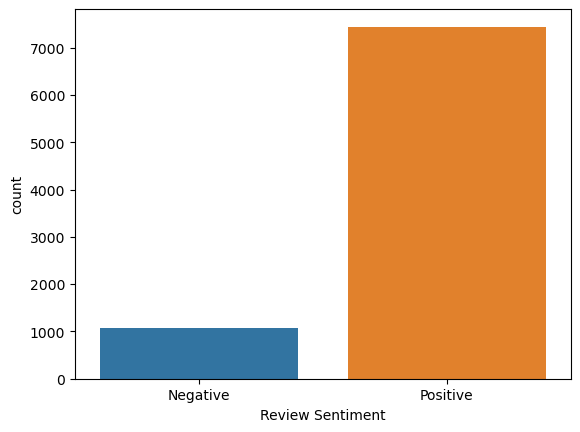

In [29]:
sns.countplot(x='Review Sentiment', data=df1)

<AxesSubplot:ylabel='Review Sentiment'>

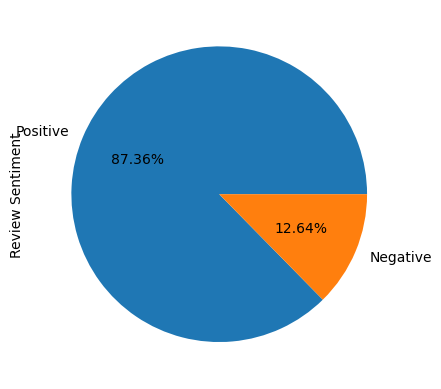

In [30]:
df1['Review Sentiment'].value_counts().plot.pie(autopct='%.2f%%')

In [31]:
df1.columns

Index(['Ratings', 'Reviewer Name', 'Review Title', 'Place of Review',
       'Up Votes', 'Down Votes', 'Month', 'Review text', 'Review Sentiment'],
      dtype='object')

In [33]:
### Convert DataFrame into csv file

df1.to_csv('data/data.csv')